In [26]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import re
import string
from tensorflow.keras.layers import TextVectorization , Input,Embedding,SimpleRNN,Dense,Bidirectional,LSTM,Dropout,GRU,Conv1D,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import gensim.downloader as api
import random

## Data Preperation

In [2]:
train_ds,val_ds,test_ds = tfds.load('imdb_reviews',split=['train','test[:50%]','test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2KDPS4/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2KDPS4/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2KDPS4/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
for review,lable in train_ds.take(2):
  print(review)
  print(lable)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [4]:
def standardization(input_data):
  lower_case = tf.strings.lower(input_data)
  no_tag = tf.strings.regex_replace(lower_case , "<[^>]+>","")
  output = tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")
  return output

In [5]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [6]:
vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = SEQUENCE_LENGTH
)

In [7]:
training_data = train_ds.map(lambda x,y:x)
vectorize_layer.adapt(training_data)

In [8]:
def vectorizer(review,lable):
  return vectorize_layer(review) , lable

In [9]:
train_dataset = train_ds.map(vectorizer)
validation_dataset = val_ds.map(vectorizer)

In [10]:
BATCH_SIZE=32
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=validation_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
for review,lable in train_dataset.take(1):
  print(review.shape)
  print(lable)

(32, 250)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


## Transfer learning

In [14]:
word2vec = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [15]:
word2vec.vectors.shape

(3000000, 300)

In [18]:
word2vec.key_to_index

{'</s>': 0,
 'in': 1,
 'for': 2,
 'that': 3,
 'is': 4,
 'on': 5,
 '##': 6,
 'The': 7,
 'with': 8,
 'said': 9,
 'was': 10,
 'the': 11,
 'at': 12,
 'not': 13,
 'as': 14,
 'it': 15,
 'be': 16,
 'from': 17,
 'by': 18,
 'are': 19,
 'I': 20,
 'have': 21,
 'he': 22,
 'will': 23,
 'has': 24,
 '####': 25,
 'his': 26,
 'an': 27,
 'this': 28,
 'or': 29,
 'their': 30,
 'who': 31,
 'they': 32,
 'but': 33,
 '$': 34,
 'had': 35,
 'year': 36,
 'were': 37,
 'we': 38,
 'more': 39,
 '###': 40,
 'up': 41,
 'been': 42,
 'you': 43,
 'its': 44,
 'one': 45,
 'about': 46,
 'would': 47,
 'which': 48,
 'out': 49,
 'can': 50,
 'It': 51,
 'all': 52,
 'also': 53,
 'two': 54,
 'after': 55,
 'first': 56,
 'He': 57,
 'do': 58,
 'time': 59,
 'than': 60,
 'when': 61,
 'We': 62,
 'over': 63,
 'last': 64,
 'new': 65,
 'other': 66,
 'her': 67,
 'people': 68,
 'into': 69,
 'In': 70,
 'our': 71,
 'there': 72,
 'A': 73,
 'she': 74,
 'could': 75,
 'just': 76,
 'years': 77,
 'some': 78,
 'U.S.': 79,
 'three': 80,
 'million': 81

In [20]:
len(word2vec['the'])

300

In [23]:
word2vec.most_similar('man')

[('woman', 0.7664012908935547),
 ('boy', 0.6824871301651001),
 ('teenager', 0.6586930155754089),
 ('teenage_girl', 0.6147903203964233),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585119128227234),
 ('Robbery_suspect', 0.5584409832954407),
 ('teen_ager', 0.5549196600914001),
 ('men', 0.5489763021469116)]

In [33]:
pretrained_embeddings=[]

In [34]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [36]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(np.random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))#reloaded_word_vectors[vectorize_layer.get_vocabulary()[i]])
  if i%1000==0:
    print('iis====================================',i)


nosolution
iis==================================== 0
[UNK]
nosolution
and
toupper
a
toupper
of
toupper
to
toupper
doesnt
nosolution
didnt
nosolution
isnt
nosolution
wasnt
nosolution
10
nosolution
80s
nosolution
20
nosolution
70s
nosolution
iis==================================== 1000
15
nosolution
12
nosolution
30
nosolution
humour
toupper
100
nosolution
hasnt
nosolution
90
nosolution
shouldnt
nosolution
favourite
toupper
theatre
toupper
60s
nosolution
40
nosolution
lowbudget
nosolution
tarzan
toupper
50
nosolution
90s
nosolution
1950s
nosolution
iis==================================== 2000
keaton
toupper
welles
toupper
50s
nosolution
1010
nosolution
11
nosolution
1970s
nosolution
overthetop
nosolution
sinatra
toupper
columbo
toupper
1980s
nosolution
25
nosolution
1930s
nosolution
14
nosolution
13
nosolution
bmovie
nosolution
aint
toupper
pacino
toupper
moviethe
nosolution
writerdirector
nosolution
itthe
nosolution
lugosi
toupper
hitchcock
toupper
810
nosolution
iis===================

In [37]:
pretrained_embeddings_array=np.array(pretrained_embeddings)
print(pretrained_embeddings_array.shape)

(10000, 300)


In [39]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=False,
    ),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 248, 32)           28832     
                                                                 
 flatten_2 (Flatten)         (None, 7936)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                253984    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3282849 (12.52 MB)
Trainable params: 282

In [40]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics = ['accuracy'])

In [41]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    )

Epoch 1/10
782/782 [==============================] - 57s 71ms/step - loss: 0.6949 - accuracy: 0.5122 - val_loss: 0.6929 - val_accuracy: 0.5081
Epoch 2/10
782/782 [==============================] - 55s 70ms/step - loss: 0.6460 - accuracy: 0.6094 - val_loss: 0.5286 - val_accuracy: 0.7616
Epoch 3/10
782/782 [==============================] - 53s 67ms/step - loss: 0.4707 - accuracy: 0.7864 - val_loss: 0.4401 - val_accuracy: 0.8034
Epoch 4/10
782/782 [==============================] - 92s 118ms/step - loss: 0.4097 - accuracy: 0.8212 - val_loss: 0.4155 - val_accuracy: 0.8133
Epoch 5/10
782/782 [==============================] - 61s 78ms/step - loss: 0.3742 - accuracy: 0.8404 - val_loss: 0.4021 - val_accuracy: 0.8206
Epoch 6/10
782/782 [==============================] - 56s 72ms/step - loss: 0.3451 - accuracy: 0.8573 - val_loss: 0.4006 - val_accuracy: 0.8229
Epoch 7/10
782/782 [==============================] - 55s 70ms/step - loss: 0.3196 - accuracy: 0.8684 - val_loss: 0.3937 - val_accuracy

[]

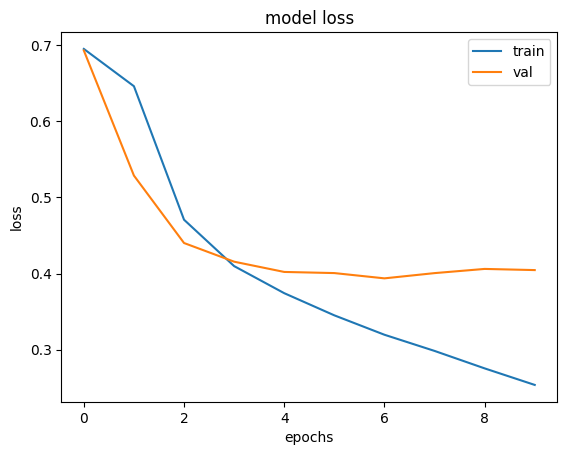

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('model loss')
plt.legend(['train','val'])
plt.plot()

[]

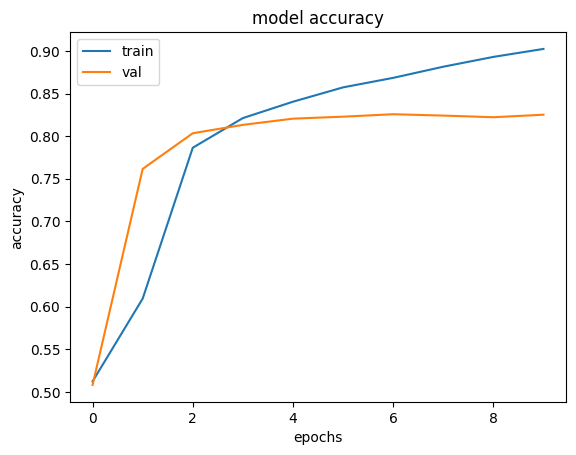

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('model accuracy')
plt.legend(['train','val'])
plt.plot()

In [44]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

391/391 [==============================] - 14s 34ms/step - loss: 0.3969 - accuracy: 0.8253


[0.39690354466438293, 0.8252800107002258]

# Testing

In [64]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very intresting, i love the fact that the actors do a great job in showing how people lived in the 18th century. But atleast this movie recreates this scenes! "],
                                              ["very intresting start, , so in all i liked this movie "],])

In [65]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [66]:
model.predict(test_dataset)

2/2 [==============================] - 0s 8ms/step


array([[0.9381865 ],
       [0.48089862]], dtype=float32)